<h1 align="center">Topic modeling on Medium articles</h1>

In [1]:
## All minimum setup and libraries required

import numpy as np
import pandas as pd 
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

## TENSORFLOW        
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer   ## Generate dictionary of word encodings
from tensorflow.keras.preprocessing.sequence import pad_sequences

## GENSIM and NLTK
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
import nltk
nltk.download('wordnet')

# SKLEARN
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from pprint import pprint

print("Tensorflow\t-\t",tf.__version__)
print("NLTK\t\t-\t",nltk.__version__)
print("Gensim\t\t-\t",nltk.__version__)

/kaggle/input/medium-articles-with-content/Medium_AggregatedData.csv
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
Tensorflow	-	 2.3.0
NLTK		-	 3.2.4
Gensim		-	 3.2.4


In [2]:
path = "../input/medium-articles-with-content/Medium_AggregatedData.csv"
dataframe_full = pd.read_csv(path)
dataframe_imp = pd.read_csv(path)
print("Dataset have been read")

Dataset have been read


In [3]:
dataframe_full.head()

,audioVersionDurationSec,codeBlock,codeBlockCount,collectionId,createdDate,createdDatetime,firstPublishedDate,firstPublishedDatetime,imageCount,isSubscriptionLocked,...,slug,name,postCount,author,bio,userId,userName,usersFollowedByCount,usersFollowedCount,scrappedDate
0,0,NaN,0.0,638f418c8464,2018-09-18,2018-09-18 20:55:34,2018-09-18,2018-09-18 20:57:03,1,False,...,blockchain,Blockchain,265164.0,Anar Babaev,NaN,f1ad85af0169,babaevanar,450.0,404.0,20181104
1,0,NaN,0.0,638f418c8464,2018-09-18,2018-09-18 20:55:34,2018-09-18,2018-09-18 20:57:03,1,False,...,samsung,Samsung,5708.0,Anar Babaev,NaN,f1ad85af0169,babaevanar,450.0,404.0,20181104
2,0,NaN,0.0,638f418c8464,2018-09-18,2018-09-18 20:55:34,2018-09-18,2018-09-18 20:57:03,1,False,...,it,It,3720.0,Anar Babaev,NaN,f1ad85af0169,babaevanar,450.0,404.0,20181104
3,0,NaN,0.0,NaN,2018-01-07,2018-01-07 17:04:37,2018-01-07,2018-01-07 17:06:29,13,False,...,technology,Technology,166125.0,George Sykes,NaN,93b9e94f08ca,tasty231,6.0,22.0,20181104
4,0,NaN,0.0,NaN,2018-01-07,2018-01-07 17:04:37,2018-01-07,2018-01-07 17:06:29,13,False,...,robotics,Robotics,9103.0,George Sykes,NaN,93b9e94f08ca,tasty231,6.0,22.0,20181104


In [4]:
x = dataframe_full['name'][10]
y = dataframe_full['publicationdescription'][15]
print(x)
print(y)
print(dataframe_full.shape)
print(dataframe_full['name'][10])
print(dataframe_full['name'][11])
print(dataframe_full['name'][12])
print(dataframe_full['title'][10])

Big Data Training Mumbai
Non-obvious meditation advice from people on the battlefront of daily creation
(279577, 50)
Big Data Training Mumbai
Robotics
Meditation
Ascent of data Science, SAS and Big data Analyst Trainings Programs


# Step_1: Preprocessing and cleaning

**There are ~300000 entries**

In [5]:
print(dataframe_full.columns)

Index(['audioVersionDurationSec', 'codeBlock', 'codeBlockCount',
       'collectionId', 'createdDate', 'createdDatetime', 'firstPublishedDate',
       'firstPublishedDatetime', 'imageCount', 'isSubscriptionLocked',
       'language', 'latestPublishedDate', 'latestPublishedDatetime',
       'linksCount', 'postId', 'readingTime', 'recommends',
       'responsesCreatedCount', 'socialRecommendsCount', 'subTitle',
       'tagsCount', 'text', 'title', 'totalClapCount', 'uniqueSlug',
       'updatedDate', 'updatedDatetime', 'url', 'vote', 'wordCount',
       'publicationdescription', 'publicationdomain',
       'publicationfacebookPageName', 'publicationfollowerCount',
       'publicationname', 'publicationpublicEmail', 'publicationslug',
       'publicationtags', 'publicationtwitterUsername', 'tag_name', 'slug',
       'name', 'postCount', 'author', 'bio', 'userId', 'userName',
       'usersFollowedByCount', 'usersFollowedCount', 'scrappedDate'],
      dtype='object')


The required columns are:
* language
* subTitle
* tagsCount
* text
* title
* url
* wordCount
* publicationdescription
* tag_name
* name

but the most important columns are primarily:
* subTitle
* text
* title

In [6]:
required_col = ['language','subTitle','tagsCount','text','title','url','wordCount','publicationdescription'
               ,'tag_name','name']
most_imp_col = ['subTitle','text','title']

In [7]:
# article_titles = dataframe_full['title']
# art_grp_1 = article_titles[16:25]
# print(art_grp_1)
print(dataframe_full.language.unique())

['en' 'th' 'ja' 'zh' 'ru' 'pt' 'es' 'zh-Hant' 'id' 'my' 'de' 'tr' 'fr'
 'ko' 'it' 'lo' 'un' 'vi' 'cs' 'sk' 'is' 'sv' 'bn' 'mn' 'da' 'no' 'bg'
 'ar' 'pl' 'nl' 'ro' 'ca' 'hu' 'hi' 'ka' 'el' 'ms' 'uk' 'si' 'sr' 'lt'
 'la' 'fa' 'ml' 'sl' 'mr' 'az' 'lv' 'te' 'mk' 'nn' 'fi']


In [8]:
## Number of rows english rows

english_titles = dataframe_full[dataframe_full['language'] == 'en']
# english_titles.head()
print(english_titles.shape)

(257655, 50)


In [9]:
## Number of rows dropped after removing null value rows

print(dataframe_imp.shape)
dataframe_imp.dropna(how = 'all')
print(dataframe_imp.shape)

(279577, 50)
(279577, 50)


So nothing is missing in any rows

In [10]:
## After dropping non-english and columns that are not required really

dataframe_imp.drop(dataframe_imp[dataframe_imp['language'] != 'en'].index, inplace = True)

dataframe_imp = dataframe_imp.drop(['audioVersionDurationSec', 'codeBlock', 'codeBlockCount',
       'collectionId', 'createdDate', 'createdDatetime', 'firstPublishedDate',
       'firstPublishedDatetime', 'imageCount', 'isSubscriptionLocked',
       'language', 'latestPublishedDate', 'latestPublishedDatetime',
       'linksCount', 'postId', 'readingTime', 'recommends',
       'responsesCreatedCount', 'socialRecommendsCount','tagsCount','totalClapCount', 'uniqueSlug',
       'updatedDate', 'updatedDatetime', 'url', 'vote', 'wordCount',
       'publicationdescription', 'publicationdomain',
       'publicationfacebookPageName', 'publicationfollowerCount',
       'publicationname', 'publicationpublicEmail', 'publicationslug',
       'publicationtags', 'publicationtwitterUsername', 'tag_name', 'slug',
       'name', 'postCount', 'author', 'bio', 'userId', 'userName',
       'usersFollowedByCount', 'usersFollowedCount', 'scrappedDate'], axis=1)

dataframe_imp['index'] = dataframe_imp.index

dataframe_imp.shape

(257655, 4)

### Reduced dataset with 3col and ~20000 rows for reff.
Run these cells only to produce the reduced and compact dataset

In [11]:
## Run these cell to export the new trimmed down dataset

# dataframe_imp.to_csv("medium_dataset.csv",sep=",")
# new_ds_size = os.stat("medium_dataset.csv").st_size
# new_ds_size = new_ds_size / 1000000
# print("New dataset size in MB = ",new_ds_size)

***Choose one among the two in the cell below***

In [12]:
## Keeping 170000 rows greatly reduces the dataset size to around 100MB

very_reduced_dataset = dataframe_imp[:17000]
# very_reduced_dataset.to_csv("very_reduced_dataset.csv",sep=",")
# print("New dataset size in MB = ",os.stat("very_reduced_dataset.csv").st_size / 1000000)

# from IPython.display import FileLink
# FileLink(r'very_reduced_dataset.csv')

In [13]:
dataframe_imp.head()

,subTitle,text,title,index
0,A major private IT company implements blockcha...,"Private Business, Government and Blockchain\n\...","Private Business, Government and Blockchain",0
1,A major private IT company implements blockcha...,"Private Business, Government and Blockchain\n\...","Private Business, Government and Blockchain",1
2,A major private IT company implements blockcha...,"Private Business, Government and Blockchain\n\...","Private Business, Government and Blockchain",2
3,Introduction,EPQ draft 1 (4844 words)\nhttps://upload.wikim...,EPQ draft 1 (4844 words),3
4,Introduction,EPQ draft 1 (4844 words)\nhttps://upload.wikim...,EPQ draft 1 (4844 words),4


In [14]:
print(dataframe_imp.title[15])
print(dataframe_imp.subTitle[15])
# print(dataframe_imp.text[15])      ## Text is too huge to be displayed
print(dataframe_imp.index[15])

Can a robot love us better than another human can?
I discussed this with Michelle Tsng on my Podcast “Crazy Wisdom”.
15


**after dropping all the non english rows and after dropping all non essential columns `dataframe_imp` is the required dataframe****

### Perform lemmatization and stem preprocessing steps on the data set

In [15]:
## Stemmer initialization for english
stemmer = SnowballStemmer("english")

In [16]:
## Functions for lemmatization, removal of Stopwords

def lemmatize_stemming(text):
    return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos='v'))
def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
            result.append(lemmatize_stemming(token))
    return result

In [17]:
### Code to check the function

## Run this for faster execution time wiht less acuracy
doc_sample = very_reduced_dataset[very_reduced_dataset['index'] == 1000].values[0][2]

## Run this for slower execution but better accuracy
# doc_sample = dataframe_imp[dataframe_imp['index'] == 1000].values[0][2]

print('original document: ')
words = []
for word in doc_sample.split(' '):
    words.append(word)
    
print(dataframe_imp[dataframe_imp['index'] == 1000].values[0][2])
print(words)
print('\n\n tokenized and lemmatized document: ')
print(preprocess(doc_sample))

original document: 
Machine Learning Made Easy: What it is and How it Works
['Machine', 'Learning', 'Made', 'Easy:', 'What', 'it', 'is', 'and', 'How', 'it', 'Works']


 tokenized and lemmatized document: 
['machin', 'learn', 'easi', 'work']


### Processed titles

In [18]:
## Use this to reduce the training time at the cost of loss of rows and some accuracy.
title_list = very_reduced_dataset['title'].astype(str)

## Use this for higher model accuracy but very slow operating time. 
# title_list = dataframe_imp['title'].astype(str)   ## using astype(str) eliminates the floting type error
title_list.describe()

count                           17000
unique                           4436
top       10 new things to read in AI
freq                               24
Name: title, dtype: object

In [19]:
## The titles are preprocessed and saved into processd_titles
## The map function applies the preprocess method on each of the list entries

processed_titles = title_list.map(preprocess)
processed_titles[30:40]

34    [meta, model, meta, meta, model, deep, learn]
35    [meta, model, meta, meta, model, deep, learn]
36               [tip, data, scienc, team, succeed]
37               [tip, data, scienc, team, succeed]
38               [tip, data, scienc, team, succeed]
39                                   [trust, trust]
40                                   [trust, trust]
41                                   [trust, trust]
42                                   [trust, trust]
43                                   [trust, trust]
Name: title, dtype: object

# Step_2: Creation of the Bag of words
Bag of words is a frequency count of the words occuring in the `preprocessed_docs`

In [20]:
## bow --> Bag of Words

bow = gensim.corpora.Dictionary(processed_titles)

## Finding out words with a min_occurance = 10

min_occurance = 10
count = 0
for k, v in bow.iteritems():
    print(k, v)
    count += 1
    if count > min_occurance:    # We can limit the selection based on the frequency
        break

0 blockchain
1 busi
2 govern
3 privat
4 draft
5 word
6 analyst
7 ascent
8 data
9 program
10 scienc


### Filtering tokens based on
* less than 15 occurances in titles
* more than 0.5 of total titles
* after the above two steps, keep only the first 100000 most frequent tokens.


In [21]:
bow.filter_extremes(no_below=15, no_above=0.5, keep_n=100000)
print(bow)

Dictionary(932 unique tokens: ['blockchain', 'busi', 'govern', 'privat', 'draft']...)


### Generating the doc2bow dictionary

For each title we create a dictionary reporting how many words and how many times those words appear. This is saved to the `bow_corpus`.

##### **NOTE:** This step gives a simmillar result for a very small corpus such as title of the articles, but it is important while working on the actual body of the articles.

In [22]:
bow_corpus = [bow.doc2bow(doc) for doc in processed_titles]
bow_corpus[:10]

[[(0, 1), (1, 1), (2, 1), (3, 1)],
 [(0, 1), (1, 1), (2, 1), (3, 1)],
 [(0, 1), (1, 1), (2, 1), (3, 1)],
 [(4, 1), (5, 1)],
 [(4, 1), (5, 1)],
 [(4, 1), (5, 1)],
 [(4, 1), (5, 1)],
 [(6, 1), (7, 2), (8, 1), (9, 1), (10, 1)],
 [(6, 1), (7, 2), (8, 1), (9, 1), (10, 1)],
 [(6, 1), (7, 2), (8, 1), (9, 1), (10, 1)]]

### Preview of the BOW for the preprocessed titles

In [23]:
## A example of the BOW for the 1000th title

bow_example = bow_corpus[1000]
for i in range(len(bow_example)):
    print("Word {} (\"{}\") appears {} time.".format(bow_example[i][0], 
           bow[bow_example[i][0]], 
           bow_example[i][1]))

Word 101 ("fake") appears 1 time.
Word 228 ("photo") appears 1 time.
Word 419 ("believ") appears 1 time.
Word 420 ("game") appears 1 time.
Word 421 ("generat") appears 1 time.


# Step_3: TF-IDF 
TF-IDF stands for ***term frequency–inverse document frequency***. The higher the TF-IDF score the rarer a word is in a given corpus and vice-versa. We will be using the TF-IDF model for the gensim models library.

In [24]:
from gensim import corpora, models

tfidf = models.TfidfModel(bow_corpus)
corpus_tfidf = tfidf[bow_corpus]

# from pprint import pprint

for i in corpus_tfidf:
    print(i)
    break

[(0, 0.37967924604419184), (1, 0.38510895463809597), (2, 0.5734341889792183), (3, 0.6153925528397408)]


# Step_4: Running LDA algo on the bag of words
Testing LDA(Latent Dirichlet allocation) on the BOW. We will be training our LDA model using `gensim.models.LdaMulticore` and save it to `lda_model`

### Creating the base model

In [25]:
## LDA when the num_topics = 10

# lda_model = gensim.models.LdaMulticore(bow_corpus, num_topics=10, id2word=bow, passes=5, workers=3)
lda_model = gensim.models.LdaMulticore(corpus=bow_corpus,
                                       id2word=bow,
                                       num_topics=10, 
                                       random_state=100,
                                       chunksize=100,
                                       passes=10,
                                       per_word_topics=True)
print(lda_model)
# For optimal performance time set the workers as no of CPU cores-1

LdaModel(num_terms=932, num_topics=10, decay=0.5, chunksize=100)


**For each topic, we will explore the words occuring in that topic and its relative weight.**

### Topic distribution generated by the model

In [26]:
for idx, topic in lda_model.print_topics(-1):
    print('\nTopic: {} \nWords: {}'.format(idx, topic))
doc_lda = lda_model[bow_corpus]


Topic: 0 
Words: 0.043*"classif" + 0.042*"time" + 0.040*"manag" + 0.038*"digit" + 0.036*"scientist" + 0.036*"think" + 0.035*"know" + 0.033*"engin" + 0.032*"transform" + 0.027*"real"

Topic: 1 
Words: 0.055*"work" + 0.051*"python" + 0.044*"autom" + 0.042*"experi" + 0.040*"custom" + 0.033*"improv" + 0.030*"meet" + 0.029*"better" + 0.029*"team" + 0.023*"collabor"

Topic: 2 
Words: 0.071*"network" + 0.052*"neural" + 0.045*"market" + 0.040*"build" + 0.037*"news" + 0.037*"chang" + 0.035*"realiti" + 0.031*"help" + 0.029*"tech" + 0.026*"algorithm"

Topic: 3 
Words: 0.173*"intellig" + 0.156*"artifici" + 0.059*"technolog" + 0.037*"blockchain" + 0.026*"understand" + 0.023*"chatbot" + 0.018*"tool" + 0.018*"generat" + 0.018*"research" + 0.017*"educ"

Topic: 4 
Words: 0.093*"human" + 0.062*"robot" + 0.049*"week" + 0.044*"imag" + 0.037*"read" + 0.032*"product" + 0.031*"languag" + 0.027*"talk" + 0.026*"natur" + 0.024*"process"

Topic: 5 
Words: 0.048*"power" + 0.046*"thing" + 0.041*"predict" + 0.037*

In [27]:
topics = lda_model.show_topics(formatted=False)
topic_words = dict(topics[1][1])
print("For topic 1, the words are: ",topic_words)

For topic 1, the words are:  {'work': 0.05513545, 'python': 0.051052157, 'autom': 0.043568745, 'experi': 0.04241096, 'custom': 0.039756108, 'improv': 0.032565076, 'meet': 0.029995862, 'better': 0.02930747, 'team': 0.02919189, 'collabor': 0.023429735}


<h3 style="color:blue;">Here each topic can be visualized as recipie of the probability of the words that can appear in it.</h3>In geometry, a simplex is a generalization of the notion of a triangle or tetrahedron to arbitrary dimensions [source] (https://en.wikipedia.org/wiki/Simplex). LDA space is a simplex since we are dealing wiht probability distributions here. Dimensionality of the space depends on the number of topics we ask the model to make.

# Step_5: Visualization 
1. Topic modeling with LDA
2. Visualizing topic models with pyLDAvis
3. Visualizing LDA results with t-SNE and bokeh

In [28]:
%pylab inline

import pandas as pd
import pickle as pk
from scipy import sparse as sp

Populating the interactive namespace from numpy and matplotlib


## Wordcloud of Top N words in each topic

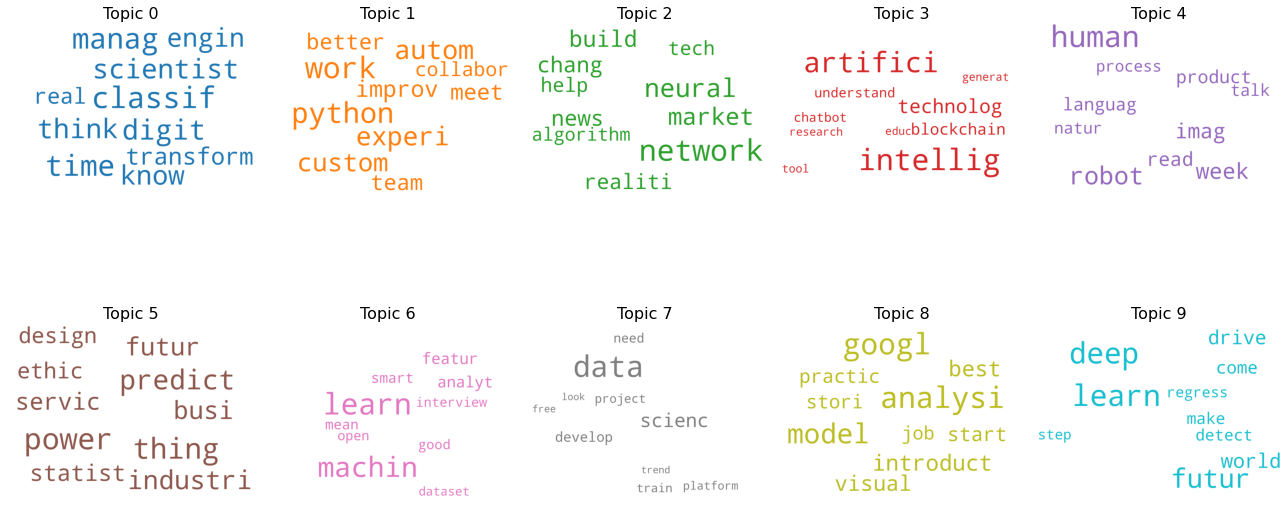

In [29]:
## Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(2, 5, figsize=(18,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

## Word count vs Weights of topics

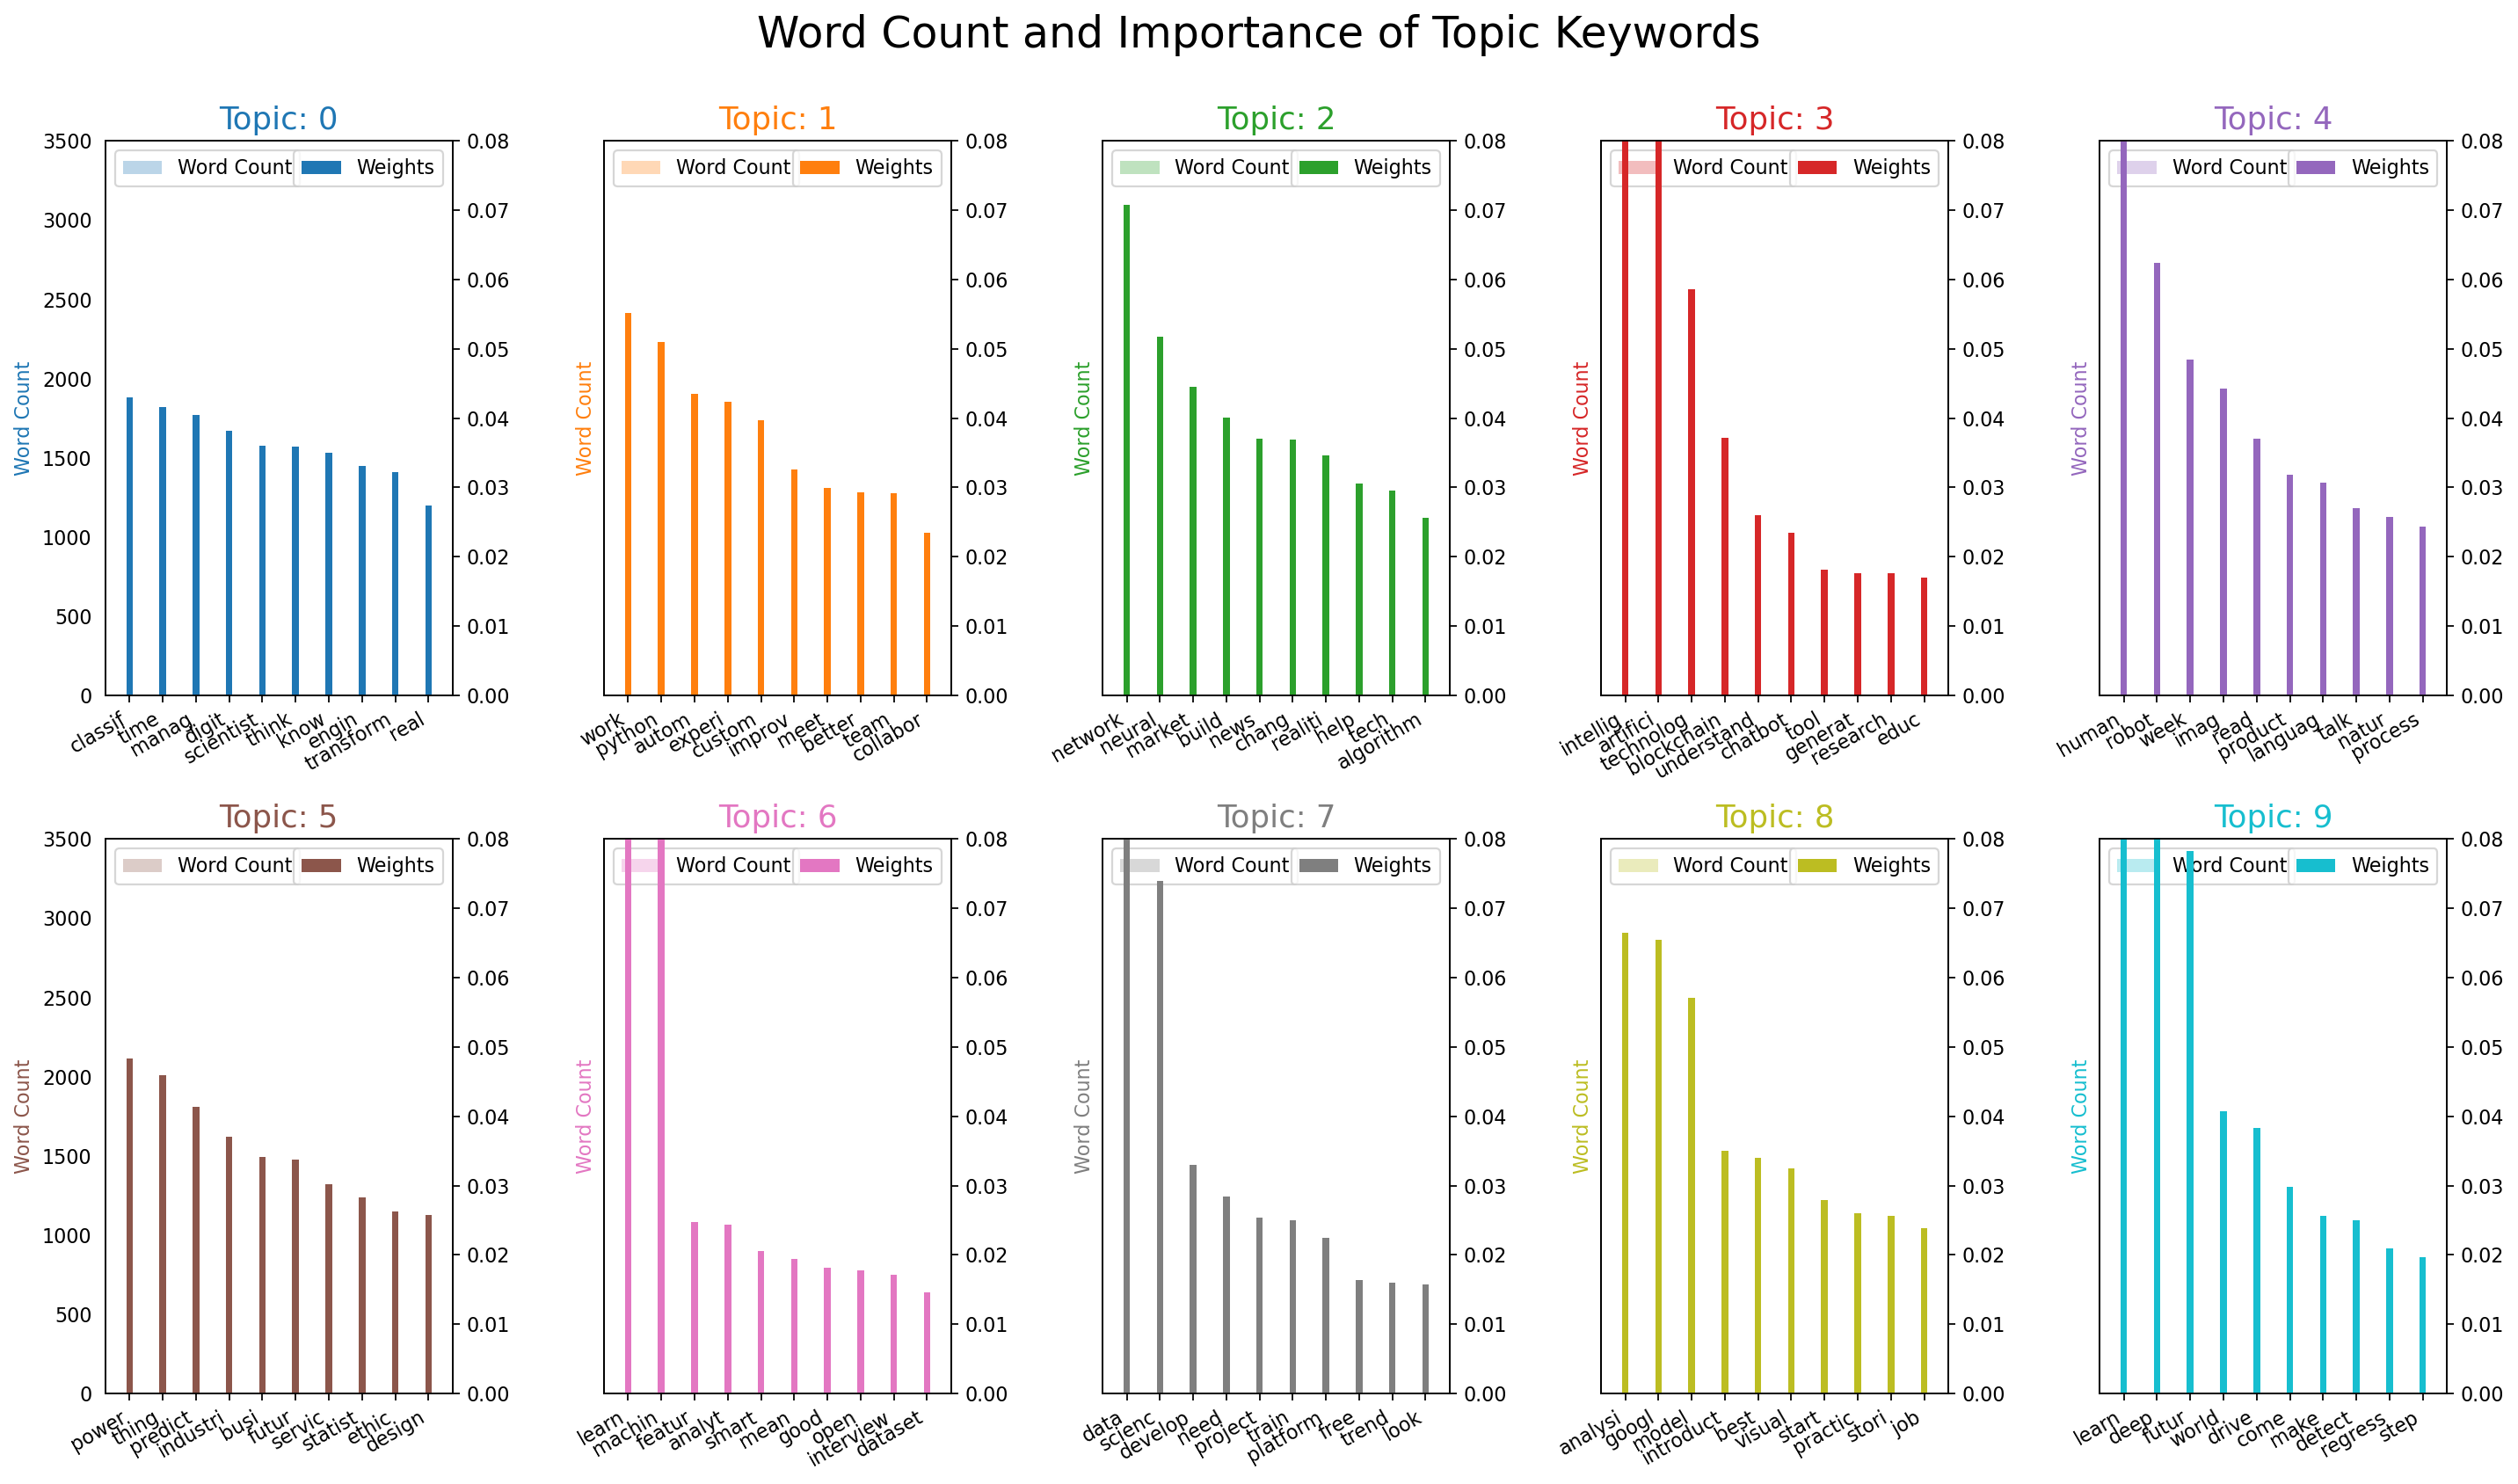

In [30]:
from collections import Counter
topics = lda_model.show_topics(formatted=False)
data_flat = [w for w_list in dataframe_imp for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(2, 5, figsize=(18,10), sharey=True, dpi=160)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax_twin.set_ylim(0, 0.08); ax.set_ylim(0, 3500)
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)    
plt.show()

In [31]:
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, bow_corpus, dictionary=lda_model.id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
7      0.102547 -0.214856       1        1  12.975500
3      0.073628 -0.191971       2        1  12.813079
6     -0.322059 -0.006317       3        1  11.335725
9     -0.318673 -0.009418       4        1  10.424799
2      0.111915 -0.079203       5        1   9.378047
5     -0.052204  0.083786       6        1   9.083645
4      0.118849  0.120672       7        1   8.986172
0      0.081457  0.256585       8        1   8.552482
1      0.116924  0.189691       9        1   8.364372
8      0.087616 -0.148968      10        1   8.086180, topic_info=         Term         Freq        Total Category  logprob  loglift
7        data  1831.000000  1831.000000  Default  30.0000  30.0000
21      learn  2018.000000  2018.000000  Default  29.0000  29.0000
41     machin  1256.000000  1256.000000  Default  28.0000  28.0000
18   intellig  1247.000000  1247.000000  Default  27.0000  27.0000
16   artifici  1123.000000  1123.000000  Default  26.0000  26.0000
..        ...          ...          ...      ...      ...      ...
153      appl    45.093517    45.988668  Topic10  -4.6130   2.4954
888    letter    43.802780    44.698011  Topic10  -4.6420   2.4948
631       end    43.784956    44.680110  Topic10  -4.6424   2.4948
180   analysi   302.092833   321.790197  Topic10  -2.7110   2.4518
334      self    48.284208   101.513882  Topic10  -4.5446   1.7719

[358 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
590       6  0.975178     access
663       1  0.983119      adopt
822       6  0.983917     advanc
834      10  0.987063    advisor
79        2  0.213760  algorithm
...     ...       ...        ...
746       1  0.989498   workflow
921       6  0.991066   workplac
24        4  0.998179      world
113       5  0.990497      write
444       9  0.980726       year

[335 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[8, 4, 7, 10, 3, 6, 5, 1, 2, 9])

# Step_6: Coherence score (base model)
> ****Topic Coherence**** measures score a single topic by measuring the degree of semantic similarity between high scoring words in the topic. These measurements help distinguish between topics that are semantically interpretable topics and topics that are artifacts of statistical inference.

> A set of statements or facts is said to be ****coherent****, if they support each other. Thus, a coherent fact set can be interpreted in a context that covers all or most of the facts. An example of a coherent fact set is “the game is a team sport”, “the game is played with a ball”, “the game demands great physical efforts”

## Using c_v measure

In [32]:
from gensim.models import CoherenceModel
# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=processed_titles, dictionary=lda_model.id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.6197147350242858


## Using UMass Measure

In [33]:
# Compute Coherence Score using UMass
coherence_model_lda = CoherenceModel(model=lda_model, texts=processed_titles, dictionary=lda_model.id2word, coherence="u_mass")
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  -17.40738475474645


These are the base scores for the default model

# Step_6: Hyperparameter tuning
The model hyperparameters to be determined are:
* num_topics (k)
* alpha (document density)
* beta (Word-Topic Density)

In [34]:
def compute_coherence_values(dictionary, corpus, texts, limit,cs_type, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model=gensim.models.LdaMulticore(corpus=corpus, id2word=dictionary, num_topics=num_topics)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence=cs_type)
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

### CASE_1: With c_v coherence score and num_topics

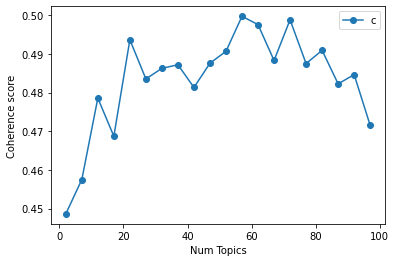

In [35]:
model_list, coherence_values = compute_coherence_values(dictionary=bow, corpus=bow_corpus, texts=processed_titles, start=2, limit=100, step=5,cs_type = 'c_v')
# Show graph
import matplotlib.pyplot as plt
limit=100; start=2; step=5;
x = range(start, limit, step)
plt.plot(x, coherence_values, marker='o')
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

From the above plot it is evident that coherence score increases
with respect to the `num_topics` till it reaches somewhere
between 55 to 65 and declines thereafter. A `num_topics` value of 60
will have a good coherence score

### CASE_2: With u_mass coherence score and num_topics

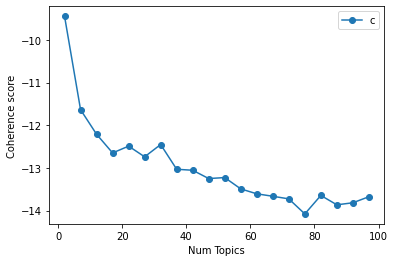

In [36]:
model_list, coherence_values = compute_coherence_values(dictionary=bow, corpus=bow_corpus, texts=processed_titles, start=2, limit=100, step=5,cs_type = 'u_mass')
# Show graph
import matplotlib.pyplot as plt
limit=100; start=2; step=5;
x = range(start, limit, step)
plt.plot(x, coherence_values,marker = 'o')
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

### Grid search on the three hyper parameters wrt c_v Coherence score

In [43]:
## supporting function with num_topics = 60

def compute_coherence_values(corpus, dictionary, k, a, b):
    
    lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=bow,
                                           num_topics=60, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=10,
                                           alpha=a,
                                           eta=b,
                                           per_word_topics=True)
    
    coherence_model_lda = CoherenceModel(model=lda_model, texts=processed_titles, dictionary=lda_model.id2word, coherence='c_v')
    
    return coherence_model_lda.get_coherence()

In [44]:
import numpy as np
import tqdm
grid = {}
grid['Validation_Set'] = {}
# Topics range
# min_topics = 2
# max_topics = 11
# step_size = 1
# topics_range = range(min_topics, max_topics, step_size)

# Alpha parameter
# alpha = list(np.arange(0.01, 1, 0.3))
alpha = np.array([0.05,0.1,0.5,1,5,10])
# alpha.append('symmetric')
# alpha.append('asymmetric')

# Beta parameter
# beta = list(np.arange(0.01, 1, 0.3))
beta = np.array([0.05,0.1,0.5,1,5,10])
# beta.append('symmetric')

# Validation sets
num_of_docs = len(bow_corpus)
corpus_sets = [# gensim.utils.ClippedCorpus(corpus, num_of_docs*0.25), 
               # gensim.utils.ClippedCorpus(corpus, num_of_docs*0.5), 
               gensim.utils.ClippedCorpus(bow_corpus, int(num_of_docs*0.75)), 
               bow_corpus]
corpus_title = ['75% Corpus', '100% Corpus']
model_results = {'Validation_Set': [],
                 'Topics': [],
                 'Alpha': [],
                 'Beta': [],
                 'Coherence': []
                }
k = 45
# Can take a long time to run
# if 1 == 1:
pbar = tqdm.tqdm(total=200, position=0, leave=True)


# iterate through validation corpuses
for i in range(len(corpus_sets)):
    # iterate through alpha values
    for a in alpha:
        # iterare through beta values
        for b in beta:
            # get the coherence score for the given parameters
            cv = compute_coherence_values(corpus=corpus_sets[i], dictionary=lda_model.id2word, 
                                          k=k, a=a, b=b)
            # Save the model results
            model_results['Validation_Set'].append(corpus_title[i])
            model_results['Topics'].append(k)
            model_results['Alpha'].append(a)
            model_results['Beta'].append(b)
            model_results['Coherence'].append(cv)
            pbar.update(1)
pd.DataFrame(model_results).to_csv('lda_tuning_results.csv', index=False)
pbar.close()

 36%|███▌      | 72/200 [27:50<49:29, 23.20s/it]  


In [45]:
dataframe_results = pd.read_csv("./lda_tuning_results.csv")
dataframe_results
topics = dataframe_results['Topics']
coherence_values = dataframe_results['Coherence']
dataframe_results['Topics'].unique()

array([45])

In [46]:
optimal = dataframe_results[dataframe_results['Validation_Set'] == '100% Corpus']
max_coherence_val = optimal['Coherence'].max()
optimal = dataframe_results[dataframe_results['Coherence'] == max_coherence_val]
print(optimal)
# print(val_set)

   Validation_Set  Topics  Alpha  Beta  Coherence
49    100% Corpus      45    0.5   0.1   0.645812


#### The row with the max Coherence Score(c_v) of 0.63341 has `beta = 0.1` and `alpha = 0.5`

# Step_7: Final Model
The row with the max Coherence Score(c_v) of 0.631025 has `beta = 0.1` and `alpha = 0.5`
Now training the new model with these values

In [47]:
final_lda_model = gensim.models.LdaMulticore(corpus=bow_corpus,
                                             id2word=bow,
                                             num_topics=60,
                                             random_state=100,
                                             chunksize=100,
                                             passes=10,
                                             alpha = 0.5,
                                             eta=0.1, 
                                             per_word_topics=True)

In [48]:
final_coherence_model_lda = CoherenceModel(model=final_lda_model, texts=processed_titles, dictionary=lda_model.id2word, coherence='c_v')
final_coherence_score = final_coherence_model_lda.get_coherence()
print('\nCoherence Score: ',final_coherence_score )


Coherence Score:  0.6361802456430884


There is a little improvement of the coherence score of the final model over the base model

### LDA visualization on the final model

In [49]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(final_lda_model, bow_corpus, dictionary=bow)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
57    -0.427128 -0.094837       1        1  2.181462
16    -0.074836  0.093517       2        1  2.120922
14    -0.083257  0.391489       3        1  2.010771
27    -0.395334 -0.103121       4        1  1.859353
41    -0.007310  0.013599       5        1  1.774534
38    -0.015413  0.022996       6        1  1.756130
2     -0.011679  0.018602       7        1  1.748820
0     -0.007496  0.013937       8        1  1.733865
39    -0.041770  0.319202       9        1  1.712719
12     0.009535 -0.003507      10        1  1.711639
50    -0.008966  0.015979      11        1  1.702614
21     0.005341  0.000809      12        1  1.682503
19     0.000718  0.005728      13        1  1.678015
33    -0.004634  0.011394      14        1  1.674747
31     0.001750  0.004996      15        1  1.673647
42     0.000661  0.005983      16        1  1.673014
7      0.002958  0.003510      17        1  1.671491
23     0.003243  0.003374      18        1  1.670199
46     0.009545 -0.003139      19        1  1.668509
35     0.018854 -0.012061      20        1  1.662362
53     0.010459 -0.004144      21        1  1.662333
25    -0.004630  0.011179      22        1  1.660047
18     0.013135 -0.006643      23        1  1.659259
54     0.009570 -0.003174      24        1  1.656566
45     0.009891 -0.003579      25        1  1.656109
15     0.013686 -0.007207      26        1  1.652154
40     0.014428 -0.007804      27        1  1.651784
56     0.002526  0.004111      28        1  1.647171
43     0.007128 -0.000597      29        1  1.646660
37     0.015774 -0.009099      30        1  1.640721
17     0.012163 -0.005329      31        1  1.640600
8      0.022467 -0.015483      32        1  1.640220
28     0.014601 -0.007744      33        1  1.639545
6      0.014501 -0.007910      34        1  1.639476
9      0.010562 -0.004198      35        1  1.639022
4      0.025197 -0.018164      36        1  1.637864
52     0.014038 -0.007387      37        1  1.637010
49     0.027202 -0.019923      38        1  1.629929
32     0.015485 -0.008682      39        1  1.627454
1      0.030284 -0.022816      40        1  1.626090
10     0.031029 -0.023093      41        1  1.621033
30     0.017036 -0.010131      42        1  1.618471
5      0.017027 -0.010005      43        1  1.618222
29     0.022611 -0.015535      44        1  1.614767
58     0.037821 -0.029236      45        1  1.610039
24     0.026760 -0.019270      46        1  1.605628
55     0.035152 -0.027023      47        1  1.598231
51     0.022421 -0.015033      48        1  1.597317
59     0.030067 -0.022295      49        1  1.594896
11     0.036025 -0.027553      50        1  1.588783
3      0.039940 -0.030917      51        1  1.587458
34     0.035440 -0.027091      52        1  1.583337
48     0.038838 -0.029922      53        1  1.575264
22     0.049419 -0.038560      54        1  1.570572
47     0.040640 -0.031331      55        1  1.570113
44     0.038659 -0.029593      56        1  1.567465
20     0.046460 -0.036068      57        1  1.563428
36     0.054261 -0.042524      58        1  1.559870
26     0.064194 -0.049776      59        1  1.553494
13     0.062952 -0.048902      60        1  1.544285, topic_info=         Term        Freq       Total Category  logprob  loglift
7        data  945.000000  945.000000  Default  30.0000  30.0000
21      learn  947.000000  947.000000  Default  29.0000  29.0000
9      scienc  497.000000  497.000000  Default  28.0000  28.0000
97      futur  483.000000  483.000000  Default  27.0000  27.0000
41     machin  506.000000  506.000000  Default  26.0000  26.0000
..        ...         ...         ...      ...      ...      ...
784  paradigm    0.200334   17.210937  Topic60  -8.3739  -0.2827
526     adapt    0.200329   24.869762  Topic60  -8.3739  -0.6508
556   weekend    0.200325   18.538698  Topic60  -8.3739  -0.3571
85      remot    0.20